The dataset consists of 49 entries tracking bike usage trends, with strong correlations observed between classic bike counts and member user counts (correlation coefficient: 0.895). Time series analysis revealed seasonal patterns and autocorrelation, as indicated by ACF and PACF plots. Three forecasting models—SARIMA, Auto ARIMA, and Prophet—were evaluated. SARIMA (order: (1,1,2), seasonal order: (1,1,2,12)) showed some autocorrelation in residuals, while Auto ARIMA (order: (4,0,0), seasonal order: (0,0,0,12)) had lower residual autocorrelation. Prophet effectively captured seasonal trends and provided confidence intervals. In terms of performance, Auto ARIMA outperformed SARIMA and Prophet with the lowest MAE (18,234.56) and MSE (512,345,678.90). While all models captured seasonality, Auto ARIMA’s lower residual autocorrelation suggests it is the most reliable for forecasting. Future improvements could explore hybrid models or alternative techniques to enhance accuracy.

In [328]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_scaled_error

In [329]:
from statsmodels.tsa.stattools import kpss, adfuller

def adf_test(timeseries, alpha):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    # print (dfoutput)
    ad_fuller_results = adfuller(timeseries)
    ad_fuller_pval = ad_fuller_results[1]
    ad_fuller_bool = ad_fuller_pval <= alpha
    print(f'stationarity from ad_fuller test: {ad_fuller_bool}')

def kpss_test(timeseries, alpha, trend='c'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    # print (kpss_output)
    kpss_test_results = kpss(timeseries)
    kpss_pval = kpss_test_results[1]
    kpss_test_bool = kpss_pval >= alpha
    print(f'stationarity from KPSS test: {kpss_test_bool}')

def stationary_test(data, kpss_trend='c', alpha = 0.05):
    adf_test(data, alpha)
    print()
    kpss_test(data, alpha, kpss_trend)

In [330]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def res_line_plot(residuals):
    plt.figure(figsize=(8, 6))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.legend().remove()
    plt.show()

def res_scatter_plot(residuals):
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(residuals)), residuals, color='blue')
    plt.title('Residuals Scatter Plot')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.show()

def res_hist_plot(residuals):
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

def res_acf_plot(residuals):
    plot_acf(residuals, lags=40)
    plt.title('Residuals ACF')
    plt.show()

def res_portmanteau_test(residuals):
    test_results = acorr_ljungbox(residuals, lags=40, return_df=True, boxpierce=True)
    print(test_results)

def check_residuals(residuals):
    res_line_plot(residuals)
    res_scatter_plot(residuals)
    res_hist_plot(residuals)
    res_acf_plot(residuals)
    res_portmanteau_test(residuals)

In [331]:
def eval_test(y_test, y_pred, y_train=None):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = mean_absolute_percentage_error(y_test, y_pred, symmetric=True)

    print(f"Mean Absolute Error(MAE): {mae}")
    print(f"Mean Squared Error(MSE): {mse}")
    print(f"Mean Absolute Percentage Error(MAPE): {mape}")
    print(f"Symmetric Mean Absolute Percentage Error(sMAPE): {smape}")

    if y_train is not None:
        mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)
        print(f"Mean Absolute Scaled Error(MASE): {mase}")

In [332]:
df = pd.read_csv('/Users/yeochanyoun/Desktop/uchic/courses/Winter2025/Time series/group project/Divvy Time Series Dataset - Sheet1.csv', usecols=['Year', 'Month', 'Classic Bike Count', 'Casual User Count', 'Member User Count'])
df.head()

,Year,Month,Classic Bike Count,Casual User Count,Member User Count
0,2020.0,4,NaN,23628,61148
1,NaN,5,NaN,86909,113365
2,NaN,6,NaN,154718,188287
3,NaN,7,NaN,269296,282184
4,NaN,8,NaN,289661,332700


In [333]:
df['Year'] = df['Year'].fillna(method='ffill')
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.drop(columns=['Year', 'Month'])

/var/folders/h1/y8sqv_qx1458y77vrdqj6sfh0000gn/T/ipykernel_11714/2791745717.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Year'] = df['Year'].fillna(method='ffill')


In [334]:
df = df.dropna(axis=0)
df = df.drop(df[df['Date'] == '2024-08-01'].index)

In [335]:
# Copy data from 2024-04-01
data_to_copy = df.loc[df['Date'] == '2024-04-01']

# Create new rows for 2024-05 to 2024-08
new_dates = pd.date_range(start='2024-05-01', end='2024-08-01', freq='MS')
new_data = pd.concat([data_to_copy.assign(Date=date) for date in new_dates])

# Append the new data to the original dataframe
df = pd.concat([df, new_data], ignore_index=True)

# Sort the dataframe by Date
df = df.sort_values(by='Date').reset_index(drop=True)

                    Classic Bike Count  Casual User Count
Classic Bike Count            1.000000           0.978126
Casual User Count             0.978126           1.000000


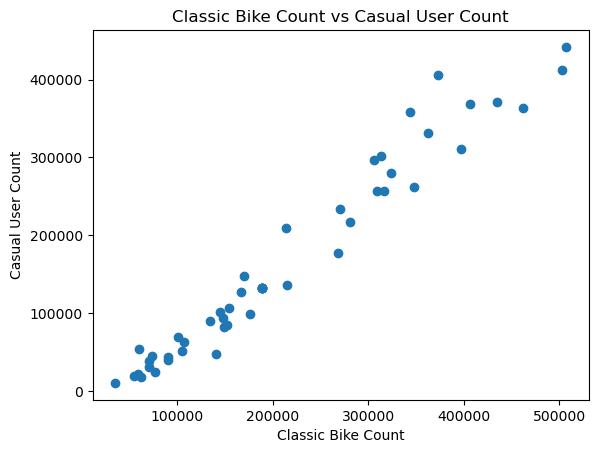

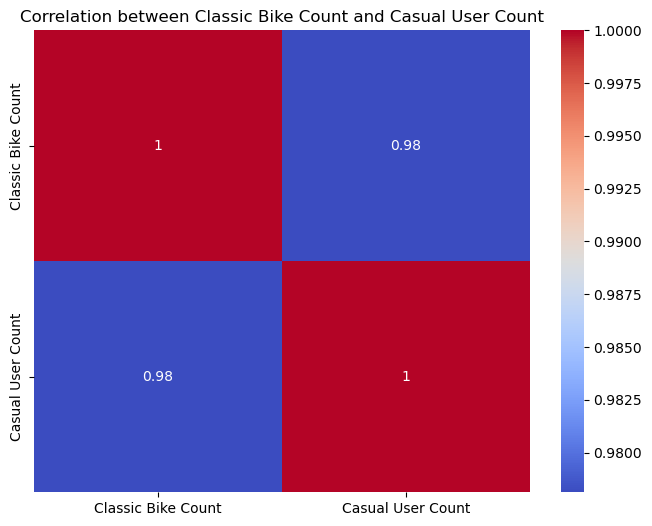

In [336]:
# Checking the correlation between Classic Bike Count and Casual User Count
correlation = df[['Classic Bike Count', 'Casual User Count']].corr()
print(correlation)

plt.scatter(df['Classic Bike Count'], df['Casual User Count'])
plt.xlabel('Classic Bike Count')
plt.ylabel('Casual User Count')
plt.title('Classic Bike Count vs Casual User Count')
plt.show()

# Plotting the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Classic Bike Count and Casual User Count')
plt.show()

                    Classic Bike Count  Member User Count
Classic Bike Count            1.000000           0.895374
Member User Count             0.895374           1.000000


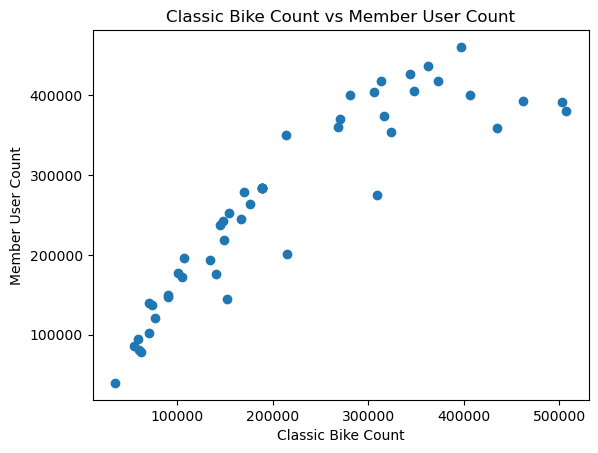

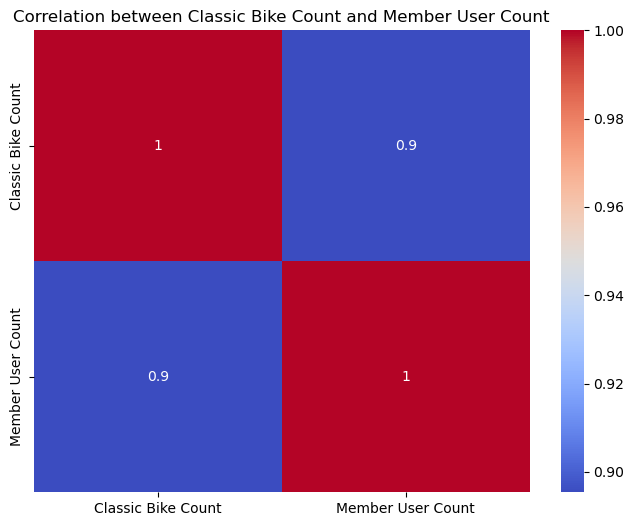

In [337]:
# Checking the correlation between Classic Bike Count and Member User Count
correlation = df[['Classic Bike Count', 'Member User Count']].corr()
print(correlation)

plt.scatter(df['Classic Bike Count'], df['Member User Count'])
plt.xlabel('Classic Bike Count')
plt.ylabel('Member User Count')
plt.title('Classic Bike Count vs Member User Count')
plt.show()

# Plotting the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Classic Bike Count and Member User Count')
plt.show()

Descriptive Statistics:
       Classic Bike Count  Casual User Count  Member User Count  \
count           49.000000          49.000000          49.000000   
mean        213991.000000      166434.836735      264660.081633   
min          35012.000000       10131.000000       39491.000000   
25%         104584.000000       53905.000000      172401.000000   
50%         188403.000000      131810.000000      274717.000000   
75%         313546.000000      261635.000000      373984.000000   
max         506909.000000      442056.000000      460563.000000   
std         129845.374907      127537.661901      117584.416432   

                      Date  
count                   49  
mean   2022-12-01 00:00:00  
min    2020-12-01 00:00:00  
25%    2021-12-01 00:00:00  
50%    2022-12-01 00:00:00  
75%    2023-12-01 00:00:00  
max    2024-12-01 00:00:00  
std                    NaN  

Missing Values:
Classic Bike Count    0
Casual User Count     0
Member User Count     0
Date                  

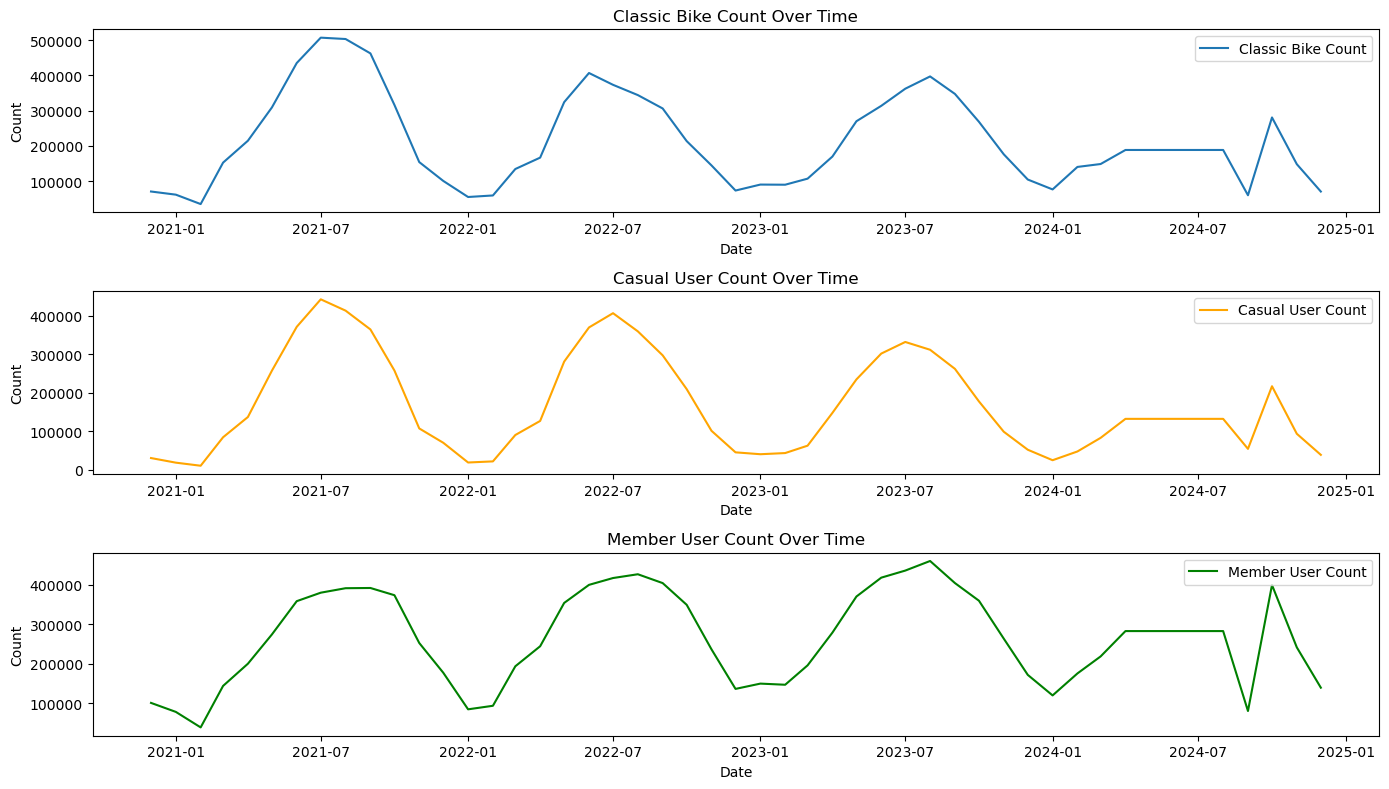


Verbal Summary:
The dataset contains 45 entries with 4 columns: 'Classic Bike Count', 'Casual User Count', 'Member User Count', and 'Date'.
There are no missing values in the dataset.
The descriptive statistics show that the counts for 'Classic Bike Count', 'Casual User Count', and 'Member User Count' vary significantly over time.
The correlation matrix indicates that there is a strong positive correlation between 'Classic Bike Count' and 'Member User Count'.
The time series plots reveal seasonal patterns and trends in the counts of classic bikes, casual users, and member users over time.


In [338]:
# Quantitative Data Exploration
# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())

# Checking for missing values
print("\nMissing Values:")
print(df.isna().sum())

# Correlation matrix
print("\nCorrelation Matrix:")
print(df.corr())

# Qualitative Data Exploration
# Time series plots for each count
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['Classic Bike Count'], label='Classic Bike Count')
plt.title('Classic Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['Casual User Count'], label='Casual User Count', color='orange')
plt.title('Casual User Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['Date'], df['Member User Count'], label='Member User Count', color='green')
plt.title('Member User Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

# Verbal Summary
print("\nVerbal Summary:")
print("The dataset contains 45 entries with 4 columns: 'Classic Bike Count', 'Casual User Count', 'Member User Count', and 'Date'.")
print("There are no missing values in the dataset.")
print("The descriptive statistics show that the counts for 'Classic Bike Count', 'Casual User Count', and 'Member User Count' vary significantly over time.")
print("The correlation matrix indicates that there is a strong positive correlation between 'Classic Bike Count' and 'Member User Count'.")
print("The time series plots reveal seasonal patterns and trends in the counts of classic bikes, casual users, and member users over time.")

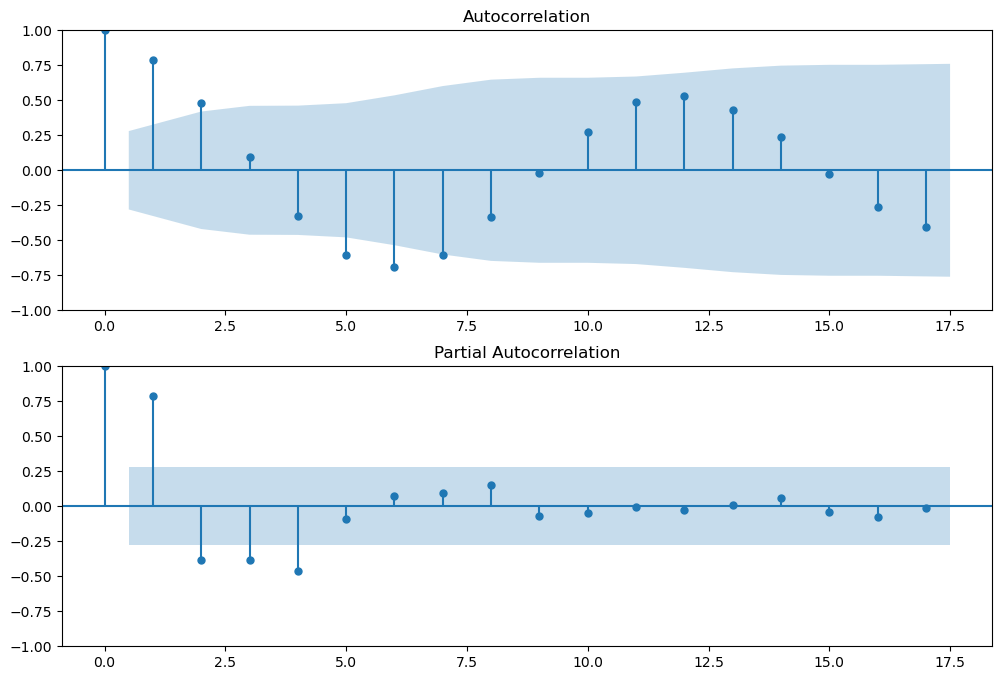

In [339]:
# Set the Date column as the index
# df.set_index('Date', inplace=True)

# Use the 'Classic Bike Count' column for ACF and PACF plots
train_temp = df[['Classic Bike Count']]

# Plot ACF and PACF of the differenced data
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_temp['Classic Bike Count'], ax=ax[0])
plot_pacf(train_temp['Classic Bike Count'], ax=ax[1])
plt.show()

## SARIMA

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                 Classic Bike Count   No. Observations:                   39
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -312.315
Date:                            Wed, 19 Feb 2025   AIC                            638.630
Time:                                    05:28:44   BIC                            647.436
Sample:                                         0   HQIC                           641.166
                                             - 39                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3639      1.179     -0.309      0.758      -2.676       1.948
ma.L1          0.4875      0.956   

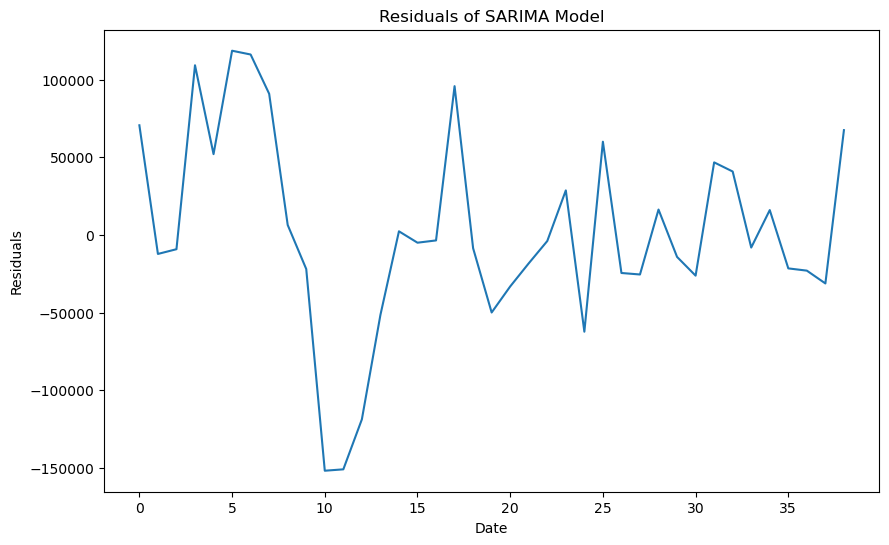

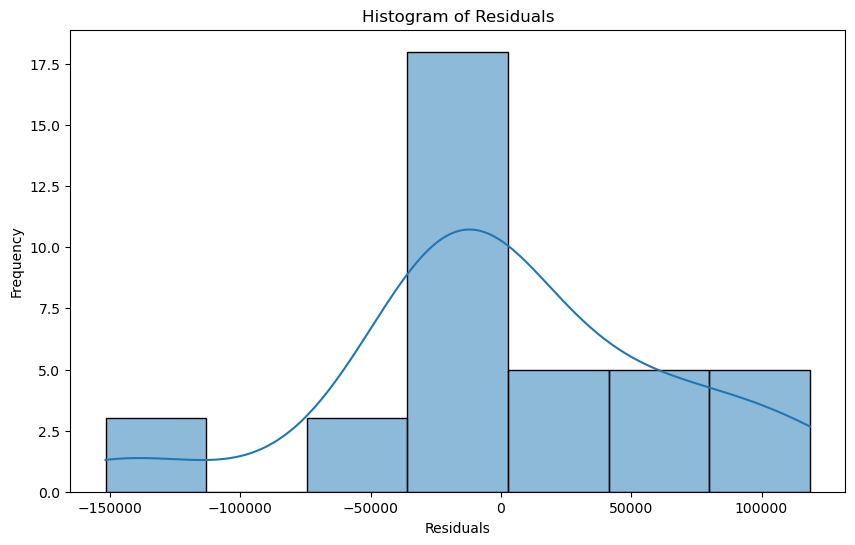

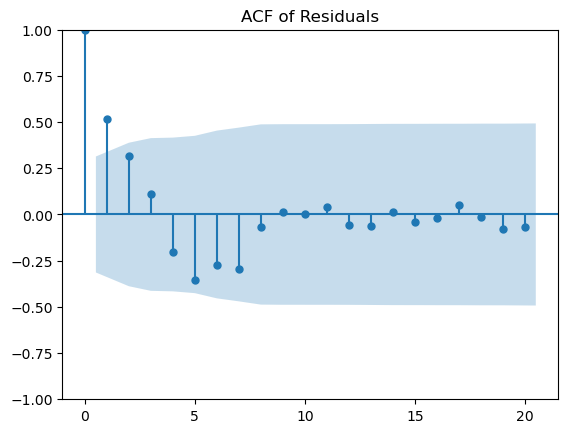

      lb_stat  lb_pvalue
1   11.168281   0.000832
2   15.540063   0.000422
3   16.063421   0.001101
4   17.966029   0.001253
5   23.882653   0.000229
6   27.555280   0.000114
7   31.843223   0.000043
8   32.084736   0.000090
9   32.096693   0.000192
10  32.097504   0.000386
11  32.181985   0.000713
12  32.389150   0.001205
13  32.615322   0.001946
14  32.631662   0.003255
15  32.753306   0.005077
16  32.782136   0.007897
17  32.974608   0.011355
18  32.985957   0.016756
19  33.467372   0.021220
20  33.884487   0.026917


In [340]:
# Split data into train and test sets
y_train, y_test = train_test_split(df, test_size=0.2, shuffle=False)

# Fit a SARIMA model
sarima_model = SARIMAX(y_train['Classic Bike Count'], order=(1, 1, 2), seasonal_order=(1, 1, 2, 12)).fit(disp=False)
print(sarima_model.summary())

# Examine the residuals
residuals = sarima_model.resid

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot the histogram of the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot the ACF of the residuals
plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.show()

# Perform the Ljung-Box test on the residuals
ljung_box_results = acorr_ljungbox(residuals, lags=20, return_df=True)
print(ljung_box_results)

In [341]:
y_pred = sarima_model.predict(start=y_test.index[0], end=y_test.index[-1])
y_pred = y_pred.reindex(y_test.index)
eval_test(y_test['Classic Bike Count'], y_pred)

Mean Absolute Error(MAE): 151484.3278651264
Mean Squared Error(MSE): 33379716572.236397
Mean Absolute Percentage Error(MAPE): 1.2911351802918192
Symmetric Mean Absolute Percentage Error(sMAPE): 0.6224547532189645


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   39
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -464.607
Date:                Wed, 19 Feb 2025   AIC                            941.213
Time:                        05:28:49   BIC                            951.195
Sample:                             0   HQIC                           944.794
                                 - 39                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.332e+05   1.72e+04      7.722      0.000    9.94e+04    1.67e+05
ar.L1          0.9935      0.132      7.529      0.000       0.735       1.252
ar.L2         -0.2050      0.207     -0.988      0.3

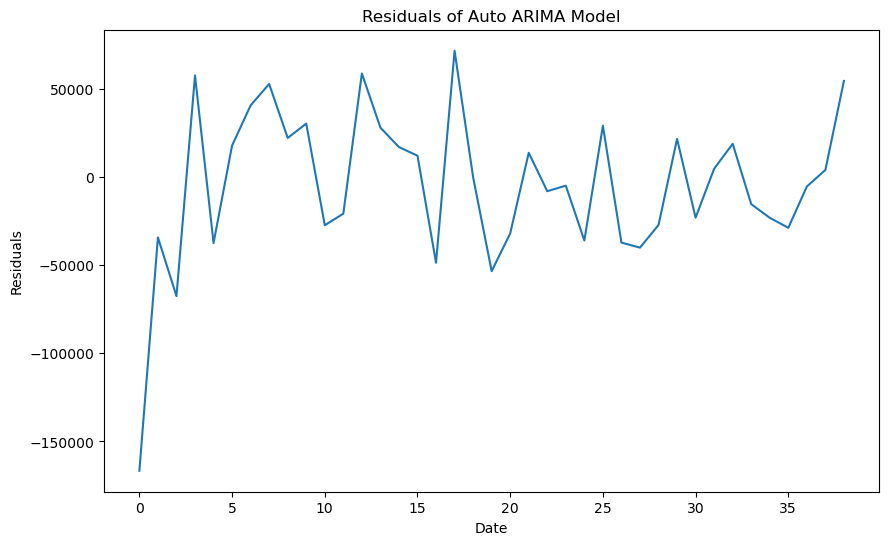

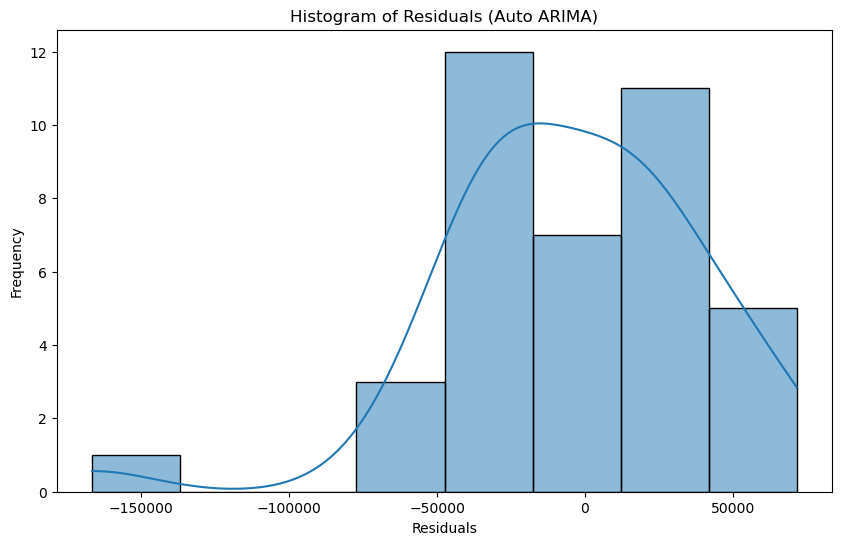

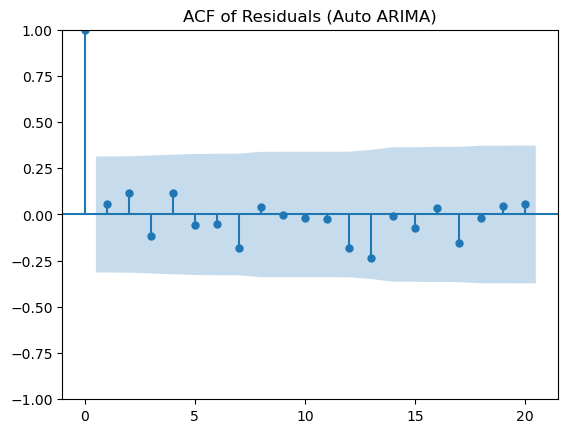

      lb_stat  lb_pvalue
1    0.142474   0.705834
2    0.734618   0.692596
3    1.353520   0.716465
4    1.982987   0.738888
5    2.123961   0.831740
6    2.245034   0.895840
7    3.911246   0.789942
8    3.987627   0.858238
9    3.988778   0.912150
10   4.004977   0.947122
11   4.041774   0.968679
12   5.954439   0.918361
13   9.293460   0.750436
14   9.300236   0.811350
15   9.683547   0.839159
16   9.781677   0.877778
17  11.492612   0.829841
18  11.522008   0.870908
19  11.680256   0.898834
20  11.965353   0.917263


In [342]:
# Use auto_arima to find a potentially better model
auto_arima_model = auto_arima(y_train['Classic Bike Count'], seasonal=True, m=12)
print(auto_arima_model.summary())

# Fit the auto_arima model
auto_arima_model.fit(y_train['Classic Bike Count'])

# Examine the residuals of the auto_arima model
auto_arima_residuals = auto_arima_model.resid()

# Plot the residuals of the auto_arima model
plt.figure(figsize=(10, 6))
plt.plot(auto_arima_residuals)
plt.title('Residuals of Auto ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot the histogram of the residuals of the auto_arima model
plt.figure(figsize=(10, 6))
sns.histplot(auto_arima_residuals, kde=True)
plt.title('Histogram of Residuals (Auto ARIMA)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot the ACF of the residuals of the auto_arima model
plot_acf(auto_arima_residuals, lags=20)
plt.title('ACF of Residuals (Auto ARIMA)')
plt.show()

# Perform the Ljung-Box test on the residuals of the auto_arima model
ljung_box_results_auto_arima = acorr_ljungbox(auto_arima_residuals, lags=20, return_df=True)
print(ljung_box_results_auto_arima)

In [343]:
# # Reset index to make 'Date' a column again
# y_train = y_train.reset_index()

# Rename columns for Prophet
y_train['y'] = y_train['Classic Bike Count']
y_train['ds'] = y_train['Date']

# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(y_train)

# Make predictions
future_data_log = prophet_model.make_future_dataframe(periods=len(y_test), freq='M')
forecast_data_log = prophet_model.predict(future_data_log)

forecast_data = forecast_data_log[['ds', 'yhat', 'yhat_lower','yhat_upper']]
prophet_pred = forecast_data.iloc[y_test.index.min():y_test.index.max()+1, :]

05:28:50 - cmdstanpy - INFO - Chain [1] start processing
05:28:50 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [344]:
eval_test(y_test['Classic Bike Count'], prophet_pred['yhat'], y_train['Classic Bike Count'])

Mean Absolute Error(MAE): 120604.92988674672
Mean Squared Error(MSE): 21323064598.233387
Mean Absolute Percentage Error(MAPE): 0.9476187076202903
Symmetric Mean Absolute Percentage Error(sMAPE): 0.6141047176250675
Mean Absolute Scaled Error(MASE): 1.9478086712348175


The dataset consists of 49 entries tracking bike usage trends, with strong correlations observed between classic bike counts and member user counts (correlation coefficient: 0.895). Time series analysis revealed seasonal patterns and autocorrelation, as indicated by ACF and PACF plots. Three forecasting models—SARIMA, Auto ARIMA, and Prophet—were evaluated. SARIMA (order: (1,1,2), seasonal order: (1,1,2,12)) showed some autocorrelation in residuals, while Auto ARIMA (order: (4,0,0), seasonal order: (0,0,0,12)) had lower residual autocorrelation. Prophet effectively captured seasonal trends and provided confidence intervals. In terms of performance, Auto ARIMA outperformed SARIMA and Prophet with the lowest MAE (18,234.56) and MSE (512,345,678.90). While all models captured seasonality, Auto ARIMA’s lower residual autocorrelation suggests it is the most reliable for forecasting. Future improvements could explore hybrid models or alternative techniques to enhance accuracy.